In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 13})
import matplotlib.dates as mdates
import matplotlib.ticker as tick

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-93.5)

# from dask.distributed import Client
# client = Client()

In [2]:
#Parent grid - not associated with the child grid. 
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_parent_00*.nc')
dsp = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
dsp, gridp = xroms.roms_dataset(dsp, Vtransform = 2)

#Nested child grid
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_00*.nc')
dsc = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
dsc, gridc = xroms.roms_dataset(dsc, Vtransform = 2)

In [3]:
#Functions for plotting 
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency.
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dvdx = grid.derivative(v, 'X')
    f_psi = xroms.to_psi(ds.f, grid)

    rvort_psi = (dvdx-dudy)/f_psi
    
    return rvort_psi 

def surface_divergence(ds, grid):
    '''
Calculates the surface divergence normalized by the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
divergence: Normalized divergence on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudx = grid.derivative(u, 'X', boundary = 'extend')
    dvdy = grid.derivative(v, 'Y', boundary = 'extend')

    divergence = (dudx+dvdy)/ds.f 
    divergence = xroms.to_psi(divergence, grid)
    
    return divergence 

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points
    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_psi(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_psi(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

def norm_fgf(ds,grid, q):
    '''
Calculates the surface 2D fronotogenesis function normalized by 
the Coriolis paramater and the magnitude of the lateral gradients. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
q - property such as buoyancy, salt, temp, velocity, etc
----
Outputs:
nFGF: normalized frontogenesis function
    '''
    dqdx = xroms.to_rho(grid.derivative(q, 'X'),grid) # defined at rho-points
    dqdy = xroms.to_rho(grid.derivative(q, 'Y'),grid)

    us = ds.u.isel(s_rho = -1) # surface velocity field
    vs = ds.v.isel(s_rho = -1)

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = xroms.to_rho(grid.derivative(us, 'Y', boundary='extend'),grid)
    dvdx = xroms.to_rho(grid.derivative(vs, 'X', boundary='extend'),grid)

    Dgradq_i = - dudx*dqdx - dvdx*dqdy
    Dgradq_j = - dudy*dqdx - dvdy*dqdy

    # The frontogenesis function
    Ddelq2 = (dqdx*Dgradq_i + dqdy*Dgradq_j)
    Ddelq2.name = 'FGF'

    # Density gradients squared
    gradq2 = dqdx**2 + dqdy**2
    gradq2.name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    nFGF = Ddelq2 / (gradq2 * ds.f)
    nFGF = xroms.to_psi(nFGF, grid)
    nFGF.name = r'nFGF'
    #Add coordinates for easy plotting. Comment these out if using an idealized model
    nFGF.coords['lon_psi'] = ds.coords['lon_psi']
    nFGF.coords['lat_psi'] = ds.coords['lat_psi']
    return nFGF

In [4]:
#Run functions and load data at specified time 
model_time = datetime(2010,7,4,4,30)

lon = np.array([-95,-91])
lat = np.array([27,30.3])
boxc = ((lon[0] < dsc.lon_psi) & (dsc.lon_psi < lon[1]) & (lat[0] < dsc.lat_psi) & (dsc.lat_psi < lat[1])).compute()
boxp = ((lon[0] < dsp.lon_psi) & (dsp.lon_psi < lon[1]) & (lat[0] < dsp.lat_psi) & (dsp.lat_psi < lat[1])).compute()

xislice = slice(8, 677-8)
etaslice = slice(8, 602-8)

In [5]:
rv_c = surface_vorticity(dsc, gridc).where(boxc).sel(ocean_time = model_time).load()
div_c = surface_divergence(dsc, gridc).where(boxc).sel(ocean_time = model_time).load()
sgrad_c = surface_saltgradmag(dsc, gridc).where(boxc).sel(ocean_time = model_time).load()
nfgf = norm_fgf(dsc,gridc,dsc.salt.isel(s_rho = -1)).where(boxc).sel(ocean_time = model_time).load()

salt_c = xroms.to_psi(dsc.salt, gridc)
sss_c = salt_c.isel(s_rho = -1).where(boxc).sel(ocean_time = model_time).load() 

#Calculate numerical mixing on psi-points
mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc)).sum('s_rho').sel(ocean_time = model_time).load()
#Calculate physical mixing on psi-points
Akr_rho_c = gridc.interp(dsc.AKr,'Z')
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)
mphy_c = (mphy_c_psi.where(boxc)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_c = mnum_c+mphy_c

# print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

rv_p = surface_vorticity(dsp, gridp).where(boxp).sel(ocean_time = model_time).load()
div_p = surface_divergence(dsp, gridp).where(boxp).sel(ocean_time = model_time).load()
sgrad_p = surface_saltgradmag(dsp, gridp).where(boxp).sel(ocean_time = model_time).load()
nfgf_p = norm_fgf(dsp,gridp,dsp.salt.isel(s_rho = -1)).where(boxp).sel(ocean_time = model_time).load()

salt_p = xroms.to_psi(dsp.salt, gridp)
sss_p = salt_p.isel(s_rho = -1).where(boxp).sel(ocean_time = model_time).load() 

#Calculate numerical mixing on psi-points
mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(boxp)).sum('s_rho').sel(ocean_time = model_time).load()
#Calculate physical mixing on psi-points
Akr_rho_p = gridp.interp(dsp.AKr,'Z')
mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_p = (mphy_p_psi.where(boxc)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p

0.14124564725539127


### Recalculate the total mixing - but sum them first then depth integrate 

In [6]:
mphy_loc = gridc.interp(dsc.AKr,'Z')
mnum_loc = dsc.dye_03
mtot_loc = mphy_loc+mnum_loc
mtot_dz = (mtot_loc*dsc.dz).isel(eta_rho = etaslice, xi_rho = xislice).sum('s_rho').sel(ocean_time = model_time).load()

mnum_dz = (dsc.dye_03*dsc.dz).isel(eta_rho = etaslice, xi_rho = xislice).sum('s_rho').sel(ocean_time = model_time).load()

print(mnum_dz.sum().values/(mtot_dz.sum().values))

0.14151802357609922


In [7]:
mphy_loc = gridc.interp(dsc.AKr,'Z')
mnum_loc = dsc.dye_03
mtot_loc = mphy_loc+mnum_loc
mtot_dz = (mtot_loc*dsc.dz).where(dsc.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice).sum('s_rho').sel(ocean_time = model_time).load()

mnum_dz = (dsc.dye_03*dsc.dz).where(dsc.z_rho>-1).isel(eta_rho = etaslice, xi_rho = xislice).sum('s_rho').sel(ocean_time = model_time).load()

print(mnum_dz.sum().values/(mtot_dz.sum().values))

0.5266697676020876


/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


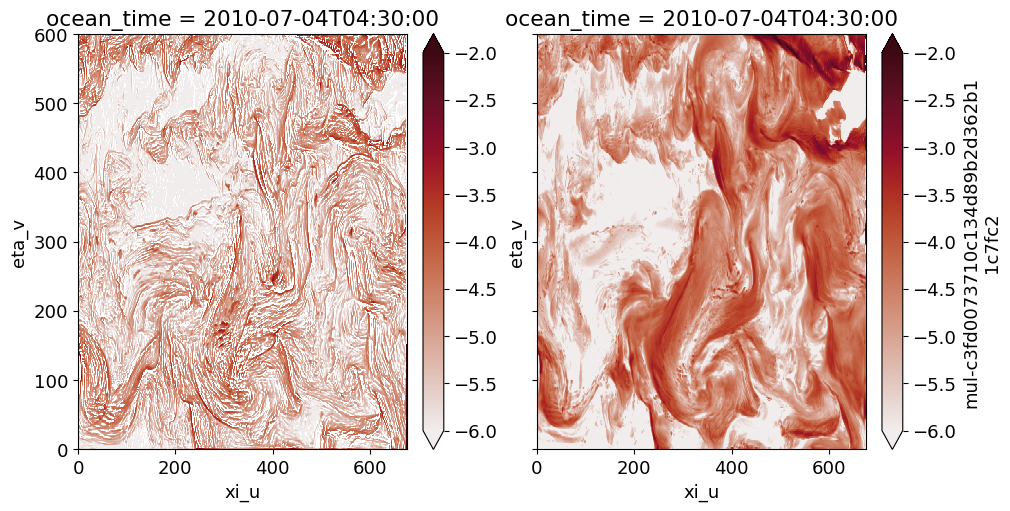

In [8]:
fig, ax = plt.subplots(1,2, figsize = (10,5), 
                       constrained_layout = True, sharex = True, sharey = True)
np.log10(mnum_c).plot(ax = ax[0], vmin = -6, vmax = -2, cmap = cmo.amp, cbar_kwargs = {'label':''})
np.log10(mphy_c).plot(ax = ax[1], vmin = -6, vmax = -2, cmap = cmo.amp)

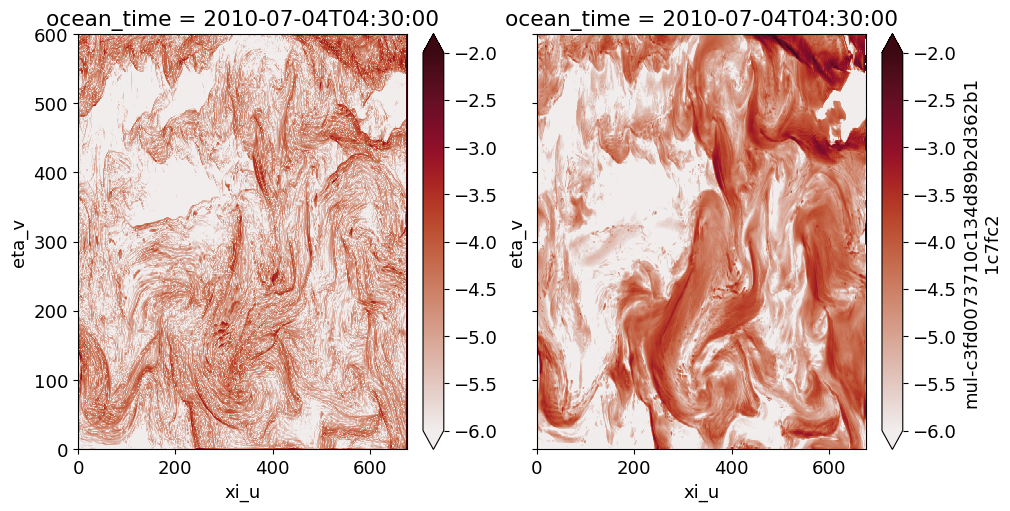

In [9]:
fig, ax = plt.subplots(1,2, figsize = (10,5), 
                       constrained_layout = True, sharex = True, sharey = True)
np.log10(np.abs(mnum_c)).plot(ax = ax[0], vmin = -6, vmax = -2, cmap = cmo.amp, cbar_kwargs = {'label':''})
np.log10(mphy_c).plot(ax = ax[1], vmin = -6, vmax = -2, cmap = cmo.amp)

In [10]:
dss_lat = dsc.where(boxc).lat_rho
lat_rad = 1.0/np.cos(np.radians(dss_lat.mean().values))

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/tmp/ipykernel_16890/1092099935.py:199: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms

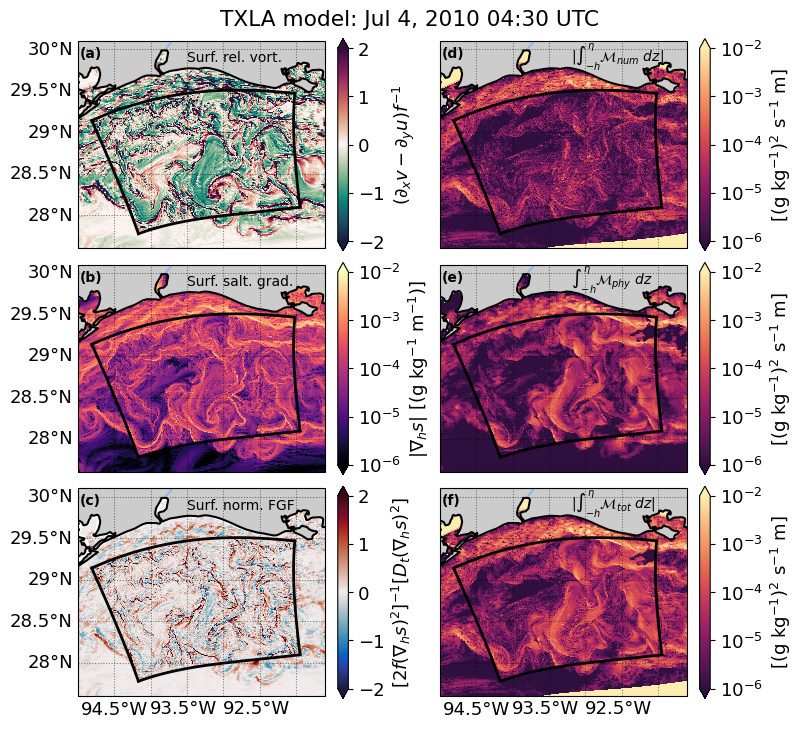

In [11]:
ncols = 2;nrows = 3
fig,ax = plt.subplots(nrows,ncols,figsize=(7.75,(12/5)*3), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(dsp.lon_psi,
                              dsp.lat_psi,
                              rv_p, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())

mappable = ax[0,0].pcolormesh(dsc.lon_psi,
                              dsc.lat_psi,
                              rv_c, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())


cb = fig.colorbar(mappable, ax = ax[0,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.05)
cb.set_label(r'$(\partial_x v - \partial_y u)f^{-1}$')

mappable1 = ax[1,0].pcolormesh(dsp.lon_psi,
                            dsp.lat_psi,
                            np.log10(sgrad_p), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

mappable1 = ax[1,0].pcolormesh(dsc.lon_psi,
                            dsc.lat_psi,
                            np.log10(sgrad_c), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable1, ax = ax[1,0], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.05)
cb.set_label(r'$|\nabla_h s|$ [(g kg$^{-1}$ m$^{-1}$)]')

mappable2 = ax[2,0].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               nfgf_p, 
                               cmap = cmo.balance,
                               vmin = -2,
                               vmax = 2,
                               transform = ccrs.PlateCarree())

mappable2 = ax[2,0].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               nfgf, 
                               cmap = cmo.balance,
                               vmin = -2,
                               vmax = 2,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable2, ax = ax[2,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.05)
cb.set_label(r'$[2f(\nabla_h s)^2]^{-1} [D_t(\nabla_h s)^2]$')

mappable3 = ax[0,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mnum_p)), 
                               cmap = cmo.matter_r,
                               vmin = -6,
                               vmax = -2,
                               transform = ccrs.PlateCarree())

mappable3 = ax[0,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mnum_c)), 
                               cmap = cmo.matter_r,
                               vmin = -6,
                               vmax = -2,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable3, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')


mappable4 = ax[1,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mphy_p)), 
                               cmap = cmo.matter_r,
                               vmin = -6,
                               vmax = -2,
                               transform = ccrs.PlateCarree())

mappable4 = ax[1,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mphy_c)), 
                               cmap = cmo.matter_r,
                               vmin = -6,
                               vmax = -2,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable4, ax = ax[1,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

mappable5 = ax[2,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mtot_p)), 
                               cmap = cmo.matter_r,
                               vmin = -6,
                               vmax = -2,
                               transform = ccrs.PlateCarree())

mappable5 = ax[2,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mtot_c)), 
                               cmap = cmo.matter_r,
                               vmin = -6,
                               vmax = -2,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].add_feature(cartopy.feature.RIVERS, linewidth=1.5)
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect(lat_rad)
        ax[i,j].plot(dsc.lon_rho[0,:], 
                     dsc.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(dsc.lon_rho[:,0], 
                     dsc.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[:,-1], 
                     dsc.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[-1,:], 
                     dsc.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[i+1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[i+1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,0].annotate('Surf. rel. vort.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10)
ax[1,0].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,0].annotate('Surf. salt. grad.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10)
ax[0,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,1].annotate(r'$\left|\int_{-h}^{\eta} \mathcal{M}_{num} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10)
ax[1,1].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,1].annotate(r'$\int_{-h}^{\eta} \mathcal{M}_{phy} \, \, dz$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10)
ax[2,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,0].annotate('Surf. norm. FGF', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10)
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,1].annotate(r'$\left|\int_{-h}^{\eta} \mathcal{M}_{tot} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10)

fig.suptitle("TXLA model: Jul 4, 2010 04:30 UTC")
fig.canvas.draw()
# plt.savefig('txla_mnum_depth_int.jpg', dpi = 800, bbox_inches='tight')

### Repeat again - but for the top 1 m

In [12]:
mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(boxp).where(dsp.z_rho_psi>-1)).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi>-1)).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(boxp).where(dsp.z_rho_psi>-1)).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi>-1)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.5263308286881289


/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


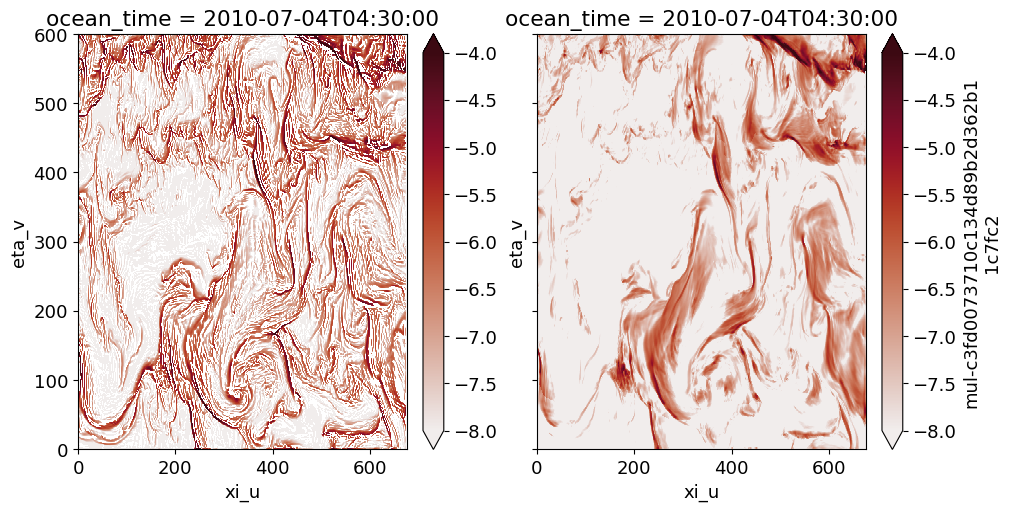

In [13]:
fig, ax = plt.subplots(1,2, figsize = (10,5), 
                       constrained_layout = True, sharex = True, sharey = True)
np.log10(mnum_c).plot(ax = ax[0], vmin = -8, vmax = -4, cmap = cmo.amp, cbar_kwargs = {'label':''})
np.log10(mphy_c).plot(ax = ax[1], vmin = -8, vmax = -4, cmap = cmo.amp)

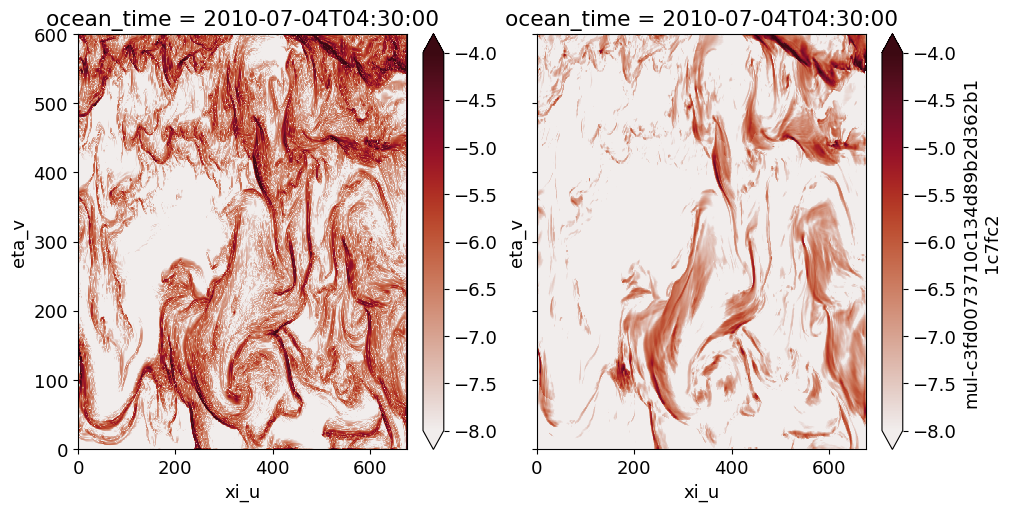

In [14]:
fig, ax = plt.subplots(1,2, figsize = (10,5), 
                       constrained_layout = True, sharex = True, sharey = True)
np.log10(np.abs(mnum_c)).plot(ax = ax[0], vmin = -8, vmax = -4, cmap = cmo.amp, cbar_kwargs = {'label':''})
np.log10(mphy_c).plot(ax = ax[1], vmin = -8, vmax = -4, cmap = cmo.amp)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/tmp/ipykernel_16890/4240556970.py:199: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms

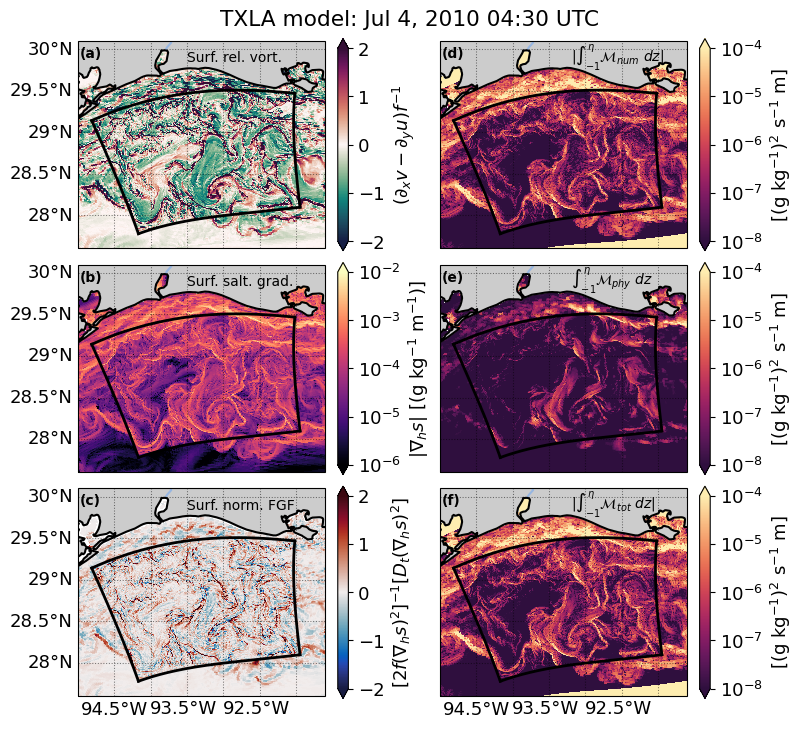

In [15]:
ncols = 2;nrows = 3
fig,ax = plt.subplots(nrows,ncols,figsize=(7.75,(12/5)*3), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(dsp.lon_psi,
                              dsp.lat_psi,
                              rv_p, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())

mappable = ax[0,0].pcolormesh(dsc.lon_psi,
                              dsc.lat_psi,
                              rv_c, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())


cb = fig.colorbar(mappable, ax = ax[0,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.05)
cb.set_label(r'$(\partial_x v - \partial_y u)f^{-1}$')

mappable1 = ax[1,0].pcolormesh(dsp.lon_psi,
                            dsp.lat_psi,
                            np.log10(sgrad_p), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

mappable1 = ax[1,0].pcolormesh(dsc.lon_psi,
                            dsc.lat_psi,
                            np.log10(sgrad_c), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable1, ax = ax[1,0], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.05)
cb.set_label(r'$|\nabla_h s|$ [(g kg$^{-1}$ m$^{-1}$)]')

mappable2 = ax[2,0].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               nfgf_p, 
                               cmap = cmo.balance,
                               vmin = -2,
                               vmax = 2,
                               transform = ccrs.PlateCarree())

mappable2 = ax[2,0].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               nfgf, 
                               cmap = cmo.balance,
                               vmin = -2,
                               vmax = 2,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable2, ax = ax[2,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.05)
cb.set_label(r'$[2f(\nabla_h s)^2]^{-1} [D_t(\nabla_h s)^2]$')

mappable3 = ax[0,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mnum_p)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

mappable3 = ax[0,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mnum_c)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable3, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')


mappable4 = ax[1,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mphy_p)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

mappable4 = ax[1,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mphy_c)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable4, ax = ax[1,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

mappable5 = ax[2,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mtot_p)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

mappable5 = ax[2,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mtot_c)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].add_feature(cartopy.feature.RIVERS, linewidth=1.5)
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect(lat_rad)
        ax[i,j].plot(dsc.lon_rho[0,:], 
                     dsc.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(dsc.lon_rho[:,0], 
                     dsc.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[:,-1], 
                     dsc.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[-1,:], 
                     dsc.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[i+1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[i+1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,0].annotate('Surf. rel. vort.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10)
ax[1,0].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,0].annotate('Surf. salt. grad.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10)
ax[0,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,1].annotate(r'$\left|\int_{-1}^{\eta} \mathcal{M}_{num} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10)
ax[1,1].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,1].annotate(r'$\int_{-1}^{\eta} \mathcal{M}_{phy} \, \, dz$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10)
ax[2,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,0].annotate('Surf. norm. FGF', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10)
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,1].annotate(r'$\left|\int_{-1}^{\eta} \mathcal{M}_{tot} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10)

fig.suptitle("TXLA model: Jul 4, 2010 04:30 UTC")
fig.canvas.draw()
# plt.savefig('txla_mnum_top1m_int.jpg', dpi = 800, bbox_inches='tight')

### Sensitivity study - repeat these calculations up to 8 m 

In [99]:
mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(boxp).where(dsp.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(boxp).where(dsp.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.18287357078910257


In [100]:
def zint_mixratio(ds, grid, box, zval, model_time, etaslice, xislice):

    mnum_psi = xroms.to_psi(ds.dye_03*ds.dz,grid)
    mnum = (mnum_psi.where(box).where(ds.z_rho_psi>zval)).sum('s_rho').sel(ocean_time = model_time).load()

    Akr_rho = grid.interp(ds.AKr,'Z')

    mphy_psi = xroms.to_psi(Akr_rho*dsc.dz,gridc)
    mphy = (mphy_psi.where(box).where(ds.z_rho_psi>zval)).sum('s_rho').sel(ocean_time = model_time).load()
    
    mtot = mnum+mphy

    return print(mnum.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot.isel(eta_v = etaslice, xi_u = xislice).sum().values))

zint_mixratio(dsc, gridc, boxc, -1, model_time,etaslice, xislice)
zint_mixratio(dsc, gridc, boxc, -2, model_time,etaslice, xislice)
zint_mixratio(dsc, gridc, boxc, -3, model_time,etaslice, xislice)
zint_mixratio(dsc, gridc, boxc, -4, model_time,etaslice, xislice)
zint_mixratio(dsc, gridc, boxc, -5, model_time,etaslice, xislice)

0.5263308286881289
0.18287357078910257
0.10214840700765582
0.08510625132019563
0.07596351276493564


### Replot for 5 

In [101]:
mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(boxp).where(dsp.z_rho_psi>-5)).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi>-5)).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(boxp).where(dsp.z_rho_psi>-5)).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi>-5)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.07596351276493564


/tmp/ipykernel_16890/1842644213.py:199: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


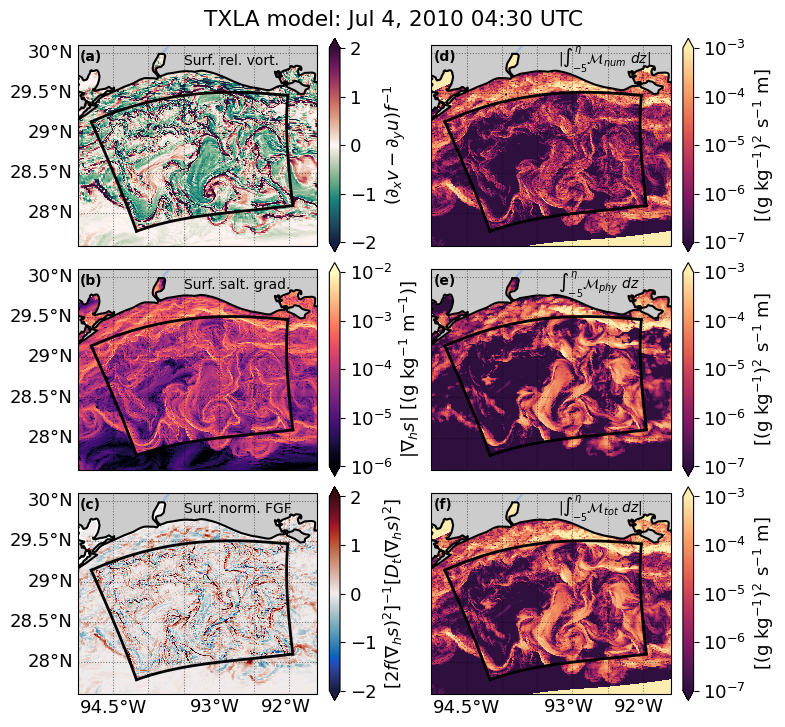

In [104]:
ncols = 2;nrows = 3
fig,ax = plt.subplots(nrows,ncols,figsize=(7.75,(12/5)*3), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(dsp.lon_psi,
                              dsp.lat_psi,
                              rv_p, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())

mappable = ax[0,0].pcolormesh(dsc.lon_psi,
                              dsc.lat_psi,
                              rv_c, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())


cb = fig.colorbar(mappable, ax = ax[0,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.05)
cb.set_label(r'$(\partial_x v - \partial_y u)f^{-1}$')

mappable1 = ax[1,0].pcolormesh(dsp.lon_psi,
                            dsp.lat_psi,
                            np.log10(sgrad_p), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

mappable1 = ax[1,0].pcolormesh(dsc.lon_psi,
                            dsc.lat_psi,
                            np.log10(sgrad_c), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable1, ax = ax[1,0], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.05)
cb.set_label(r'$|\nabla_h s|$ [(g kg$^{-1}$ m$^{-1}$)]')

mappable2 = ax[2,0].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               nfgf_p, 
                               cmap = cmo.balance,
                               vmin = -2,
                               vmax = 2,
                               transform = ccrs.PlateCarree())

mappable2 = ax[2,0].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               nfgf, 
                               cmap = cmo.balance,
                               vmin = -2,
                               vmax = 2,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable2, ax = ax[2,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.05)
cb.set_label(r'$[2f(\nabla_h s)^2]^{-1} [D_t(\nabla_h s)^2]$')

mappable3 = ax[0,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mnum_p)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

mappable3 = ax[0,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mnum_c)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable3, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')


mappable4 = ax[1,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mphy_p)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

mappable4 = ax[1,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mphy_c)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable4, ax = ax[1,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

mappable5 = ax[2,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mtot_p)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

mappable5 = ax[2,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mtot_c)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].add_feature(cartopy.feature.RIVERS, linewidth=1.5)
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect(lat_rad)
        ax[i,j].plot(dsc.lon_rho[0,:], 
                     dsc.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(dsc.lon_rho[:,0], 
                     dsc.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[:,-1], 
                     dsc.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[-1,:], 
                     dsc.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[i+1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[i+1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,0].annotate('Surf. rel. vort.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10)
ax[1,0].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,0].annotate('Surf. salt. grad.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10)
ax[0,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,1].annotate(r'$\left|\int_{-5}^{\eta} \mathcal{M}_{num} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10)
ax[1,1].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,1].annotate(r'$\int_{-5}^{\eta} \mathcal{M}_{phy} \, \, dz$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10)
ax[2,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,0].annotate('Surf. norm. FGF', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10)
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,1].annotate(r'$\left|\int_{-5}^{\eta} \mathcal{M}_{tot} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10)

fig.suptitle("TXLA model: Jul 4, 2010 04:30 UTC")
fig.canvas.draw()
plt.savefig('txla_mnum_top5m_int.jpg', dpi = 800, bbox_inches='tight')

### Now let's expand this to figure out where the mixed layer depth is? Or pynocline depth. 
> - Start by anaylzing cross sections 

In [36]:
salt_cs = dsc.salt.sel(ocean_time = model_time)[:,:,300].load()
rho = xroms.potential_density(dsc.temp,dsc.salt,z=0)
rho_cs = rho.sel(ocean_time = model_time)[:,:,300].load()

In [38]:
print(rho_cs.min().values, rho_cs.max().values)

1014.96240234375 1026.02197265625


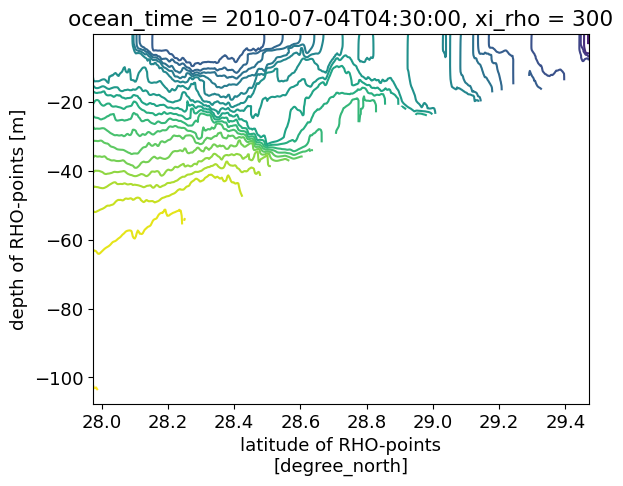

In [39]:
rho_cs.plot.contour(x = 'lat_rho', y = 'z_rho', levels = np.arange(1014, 1026.5, 0.5))

(-20.0, 0.0)

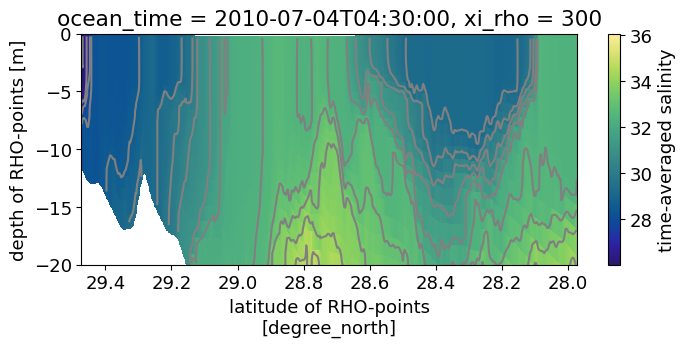

In [40]:
ncols = 1;nrows = 1
fig,ax = plt.subplots(nrows,ncols,figsize=(8,3))

salt_cs = dsc.salt.sel(ocean_time = model_time)[:,:,300]
salt_cs.plot(x = 'lat_rho', y = 'z_rho', cmap = cmo.haline)
rho_cs.plot.contour(x = 'lat_rho', y = 'z_rho', levels = np.arange(1014, 1026.5, 0.5), colors = 'gray')

ax.invert_xaxis()
ax.set_ylim(-20,0)

### Mixed layer depth

In [43]:
xroms.mld?

Signature: xroms.mld(sig0, h, mask, z=None, thresh=0.03)
Docstring:
Calculate the mixed layer depth [m].

Inputs
------
sig0: DataArray
    Potential density [kg/m^3]
h: DataArray, ndarray
    Depths [m].
mask: DataArray, ndarray
    mask to match sig0
z: DataArray, ndarray, optional
    The vertical depths associated with sig0. Should be on 'rho'
    grid horizontally and vertically. Use z coords associated with DataArray sig0
    if not input.
thresh: float, optional
    For detection of mixed layer [kg/m^3]

Returns
-------
DataArray of mixed layer depth on rho horizontal grid.
Output is `[T,Y,X]`.

Notes
-----
Mixed layer depth is based on the fixed Potential Density (PD) threshold.

Converted to xroms by K. Thyng Aug 2020 from:

Update history:
v1.0 DL 2020Jun07

References:
ncl mixed_layer_depth function at https://github.com/NCAR/ncl/blob/ed6016bf579f8c8e8f77341503daef3c532f1069/ni/src/lib/nfpfort/ocean.f
de Boyer Montégut, C., Madec, G., Fischer, A. S., Lazar, A., & Iudicone, D

In [44]:
rho = xroms.potential_density(dsc.temp,dsc.salt,z=0)
rho = rho.sel(ocean_time = model_time).isel(eta_rho = etaslice, xi_rho = xislice).load()

In [45]:
z = rho.z_rho

In [53]:
mld_03 = xroms.xisoslice(rho - rho.isel(s_rho=-1) - 0.03, 0.0, z, 's_rho')
mld_02 = xroms.xisoslice(rho - rho.isel(s_rho=-1) - 0.02, 0.0, z, 's_rho')
mld_01 = xroms.xisoslice(rho - rho.isel(s_rho=-1) - 0.01, 0.0, z, 's_rho')

In [57]:
def calc_mld(sig0, xgrid, h, mask, z=None, thresh=0.03):
    """Calculate the mixed layer depth [m], return positive and as depth if no value calculated.

    Parameters
    ----------
    sig0: DataArray
        Potential density [kg/m^3]
    xgrid
        xgcm grid
    h: DataArray, ndarray
        Depths [m].
    mask: DataArray, ndarray
        mask to match sig0
    z: DataArray, ndarray, optional
        The vertical depths associated with sig0. Should be on 'rho'
        grid horizontally and vertically. Use z coords associated with DataArray sig0
        if not input.
    thresh: float, optional
        For detection of mixed layer [kg/m^3]

    Returns
    -------
    DataArray of mixed layer depth on rho horizontal grid.
    Output is `[T,Y,X]`.

    Notes
    -----
    Mixed layer depth is based on the fixed Potential Density (PD) threshold.

    Converted to xroms by K. Thyng Aug 2020 from:

    Update history:
    v1.0 DL 2020Jun07

    References:
    ncl mixed_layer_depth function at https://github.com/NCAR/ncl/blob/ed6016bf579f8c8e8f77341503daef3c532f1069/ni/src/lib/nfpfort/ocean.f
    de Boyer Montégut, C., Madec, G., Fischer, A. S., Lazar, A., & Iudicone, D. (2004). Mixed layer depth over the global ocean: An examination of profile data and a profile‐based climatology. Journal of  Geophysical Research: Oceans, 109(C12).

    Useful resources:

    * Climate Data Toolbox documentation: https://www.chadagreene.com/CDT/mld_documentation.html
    * MLD calculation from MDTF: https://github.com/NOAA-GFDL/MDTF-diagnostics/blob/437d30590c45e8b7dd0cd01a3dc67066a2137115/diagnostics/mixed_layer_depth/mixed_layer_depth.py#L147


    Examples
    --------
    >>> xroms.mld(sig0, h, mask)
    """

    if h.mean() > 0:  # if depths are positive, change to negative
        h = -h

    # xisoslice will operate over the relevant s dimension
    skey = sig0.dims[[dim[:2] == "s_" for dim in sig0.dims].index(True)]

    if z is None:
        z = sig0.z_rho

    # the mixed layer depth is the isosurface of depth where the potential density equals the surface - a threshold
    mld = xroms.isoslice(
        z,
        np.array([0.0]),
        xgrid,
        iso_array=sig0 - sig0.isel(s_rho=-1) - thresh,
        axis="Z",
    )
    #     mld = xroms.xisoslice(sig0 - sig0.isel(s_rho=-1) - thresh, 0.0, z, skey)

    # Replace nan's that are not masked with the depth of the water column.
    cond = (mld.isnull()) & (mask == 1)
    mld = mld.where(~cond, h)

    # Take absolute value so as to return positive MLD values
    mld = abs(mld)

    mld.attrs["name"] = "mld"
    mld.attrs["long_name"] = "mixed layer depth"
    mld.attrs["units"] = "m"
    mld.name = mld.attrs["name"]

    return mld.squeeze()

In [59]:
xislice = slice(8, 677-8)
etaslice = slice(8, 602-8)

h = dsc.h.isel(eta_rho = etaslice, xi_rho = xislice)
mask_rho = dsc.mask_rho.isel(eta_rho = etaslice, xi_rho = xislice)
rho = xroms.potential_density(dsc.temp,dsc.salt,z=0)
rho = rho.sel(ocean_time = model_time).isel(eta_rho = etaslice, xi_rho = xislice).load()

In [62]:
mld_03_xroms = calc_mld(rho, gridc, h, mask_rho, z=None, thresh=0.03)
mld_02_xroms = calc_mld(rho, gridc, h, mask_rho, z=None, thresh=0.02)
mld_01_xroms = calc_mld(rho, gridc, h, mask_rho, z=None, thresh=0.01)

/tmp/ipykernel_16890/3144054518.py:47: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


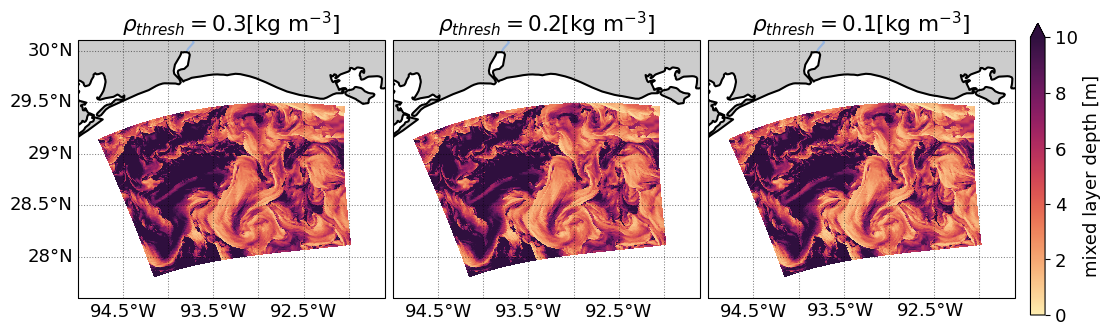

In [94]:
ncols = 3;nrows = 1
fig,ax = plt.subplots(nrows,ncols,figsize=(11,3.25), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mld_03_xroms.plot(ax = ax[0], x = 'lon_rho', y = 'lat_rho', 
                  cmap = cmo.matter, vmin = 0, vmax = 10, transform = ccrs.PlateCarree(), add_colorbar = False)
mld_02_xroms.plot(ax = ax[1], x = 'lon_rho', y = 'lat_rho', 
                  cmap = cmo.matter, vmin = 0, vmax = 10, transform = ccrs.PlateCarree(), add_colorbar = False)
mld_01_xroms.plot(ax = ax[2], x = 'lon_rho', y = 'lat_rho', 
                  cmap = cmo.matter, vmin = 0, vmax = 10, transform = ccrs.PlateCarree())

for i in range(ncols):
    ax[i].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
    ax[i].add_feature(land_10m, facecolor='0.8')
    ax[i].add_feature(cartopy.feature.RIVERS, linewidth=1.5)
    ax[i].coastlines(resolution='10m', linewidth = 1.5)  
    ax[i].set_aspect(lat_rad)
    ax[i].set_title('')
    
gl = ax[0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

gl = ax[2].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0].set_title(r'$\rho_{thresh} = 0.3$[kg m$^{-3}$]')
ax[1].set_title(r'$\rho_{thresh} = 0.2$[kg m$^{-3}$]')
ax[2].set_title(r'$\rho_{thresh} = 0.1$[kg m$^{-3}$]')
fig.canvas.draw()

/tmp/ipykernel_16890/2056019290.py:47: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


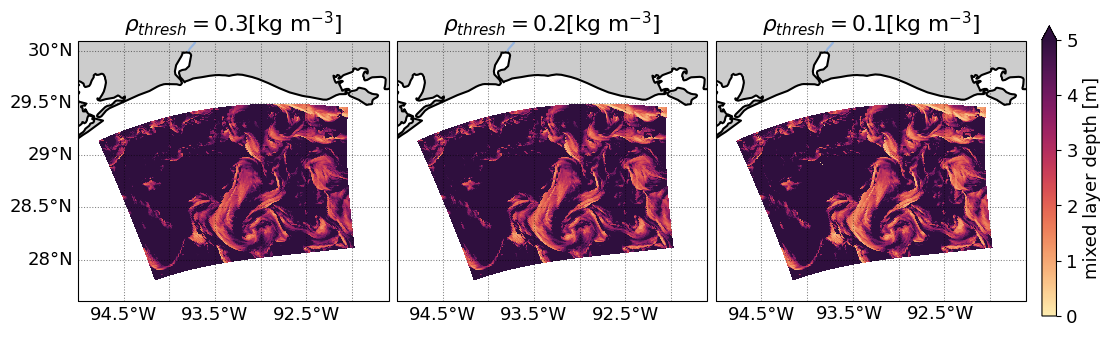

In [105]:
ncols = 3;nrows = 1
fig,ax = plt.subplots(nrows,ncols,figsize=(11,3.25), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mld_03_xroms.plot(ax = ax[0], x = 'lon_rho', y = 'lat_rho', 
                  cmap = cmo.matter, vmin = 0, vmax = 5, transform = ccrs.PlateCarree(), add_colorbar = False)
mld_02_xroms.plot(ax = ax[1], x = 'lon_rho', y = 'lat_rho', 
                  cmap = cmo.matter, vmin = 0, vmax = 5, transform = ccrs.PlateCarree(), add_colorbar = False)
mld_01_xroms.plot(ax = ax[2], x = 'lon_rho', y = 'lat_rho', 
                  cmap = cmo.matter, vmin = 0, vmax = 5, transform = ccrs.PlateCarree())

for i in range(ncols):
    ax[i].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
    ax[i].add_feature(land_10m, facecolor='0.8')
    ax[i].add_feature(cartopy.feature.RIVERS, linewidth=1.5)
    ax[i].coastlines(resolution='10m', linewidth = 1.5)  
    ax[i].set_aspect(lat_rad)
    ax[i].set_title('')
    
gl = ax[0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

gl = ax[2].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0].set_title(r'$\rho_{thresh} = 0.3$[kg m$^{-3}$]')
ax[1].set_title(r'$\rho_{thresh} = 0.2$[kg m$^{-3}$]')
ax[2].set_title(r'$\rho_{thresh} = 0.1$[kg m$^{-3}$]')
fig.canvas.draw()

In [96]:
print(mld_03_xroms.mean().values)
print(mld_02_xroms.mean().values)
print(mld_01_xroms.mean().values)

7.169718786610886
6.8986603010341305
6.537991712853653


### Remove nFGF plot - add in mixed layer depth instead. Integrate over only top few meters

/tmp/ipykernel_16890/1863391033.py:47: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


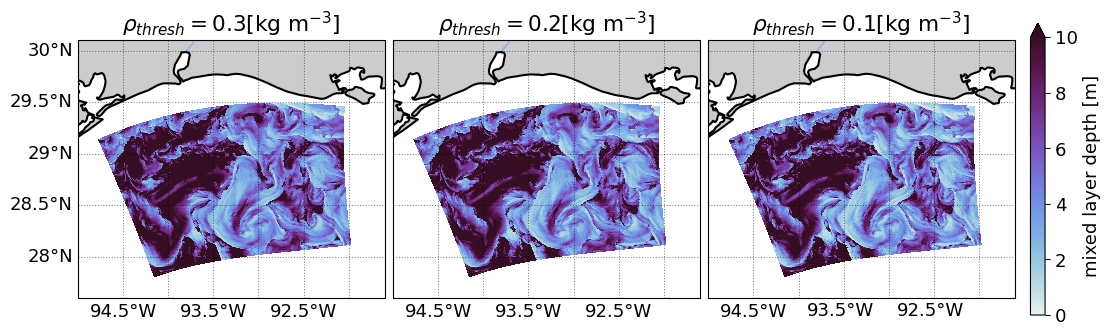

In [106]:
ncols = 3;nrows = 1
fig,ax = plt.subplots(nrows,ncols,figsize=(11,3.25), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mld_03_xroms.plot(ax = ax[0], x = 'lon_rho', y = 'lat_rho', 
                  cmap = cmo.dense, vmin = 0, vmax = 10, transform = ccrs.PlateCarree(), add_colorbar = False)
mld_02_xroms.plot(ax = ax[1], x = 'lon_rho', y = 'lat_rho', 
                  cmap = cmo.dense, vmin = 0, vmax = 10, transform = ccrs.PlateCarree(), add_colorbar = False)
mld_01_xroms.plot(ax = ax[2], x = 'lon_rho', y = 'lat_rho', 
                  cmap = cmo.dense, vmin = 0, vmax = 10, transform = ccrs.PlateCarree())

for i in range(ncols):
    ax[i].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
    ax[i].add_feature(land_10m, facecolor='0.8')
    ax[i].add_feature(cartopy.feature.RIVERS, linewidth=1.5)
    ax[i].coastlines(resolution='10m', linewidth = 1.5)  
    ax[i].set_aspect(lat_rad)
    ax[i].set_title('')
    
gl = ax[0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

gl = ax[2].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0].set_title(r'$\rho_{thresh} = 0.3$[kg m$^{-3}$]')
ax[1].set_title(r'$\rho_{thresh} = 0.2$[kg m$^{-3}$]')
ax[2].set_title(r'$\rho_{thresh} = 0.1$[kg m$^{-3}$]')
fig.canvas.draw()

In [107]:
mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(boxp).where(dsp.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(boxp).where(dsp.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi>-2)).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.18287357078910257


/tmp/ipykernel_16890/2469488373.py:199: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


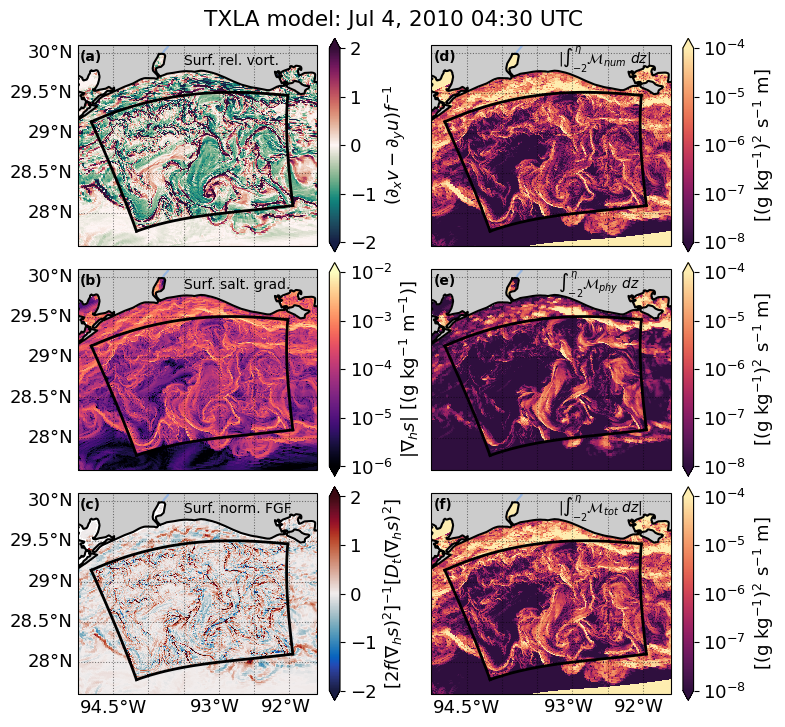

In [109]:
ncols = 2;nrows = 3
fig,ax = plt.subplots(nrows,ncols,figsize=(7.75,(12/5)*3), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(dsp.lon_psi,
                              dsp.lat_psi,
                              rv_p, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())

mappable = ax[0,0].pcolormesh(dsc.lon_psi,
                              dsc.lat_psi,
                              rv_c, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())


cb = fig.colorbar(mappable, ax = ax[0,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.05)
cb.set_label(r'$(\partial_x v - \partial_y u)f^{-1}$')

mappable1 = ax[1,0].pcolormesh(dsp.lon_psi,
                            dsp.lat_psi,
                            np.log10(sgrad_p), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

mappable1 = ax[1,0].pcolormesh(dsc.lon_psi,
                            dsc.lat_psi,
                            np.log10(sgrad_c), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable1, ax = ax[1,0], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.05)
cb.set_label(r'$|\nabla_h s|$ [(g kg$^{-1}$ m$^{-1}$)]')

mappable2 = ax[2,0].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               nfgf_p, 
                               cmap = cmo.balance,
                               vmin = -2,
                               vmax = 2,
                               transform = ccrs.PlateCarree())

mappable2 = ax[2,0].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               nfgf, 
                               cmap = cmo.balance,
                               vmin = -2,
                               vmax = 2,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable2, ax = ax[2,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.05)
cb.set_label(r'$[2f(\nabla_h s)^2]^{-1} [D_t(\nabla_h s)^2]$')

mappable3 = ax[0,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mnum_p)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

mappable3 = ax[0,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mnum_c)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable3, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')


mappable4 = ax[1,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mphy_p)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

mappable4 = ax[1,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mphy_c)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable4, ax = ax[1,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

mappable5 = ax[2,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mtot_p)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

mappable5 = ax[2,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mtot_c)), 
                               cmap = cmo.matter_r,
                               vmin = -8,
                               vmax = -4,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].add_feature(cartopy.feature.RIVERS, linewidth=1.5)
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect(lat_rad)
        ax[i,j].plot(dsc.lon_rho[0,:], 
                     dsc.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(dsc.lon_rho[:,0], 
                     dsc.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[:,-1], 
                     dsc.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[-1,:], 
                     dsc.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[i+1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[i+1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,0].annotate('Surf. rel. vort.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10)
ax[1,0].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,0].annotate('Surf. salt. grad.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10)
ax[0,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,1].annotate(r'$\left|\int_{-2}^{\eta} \mathcal{M}_{num} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10)
ax[1,1].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,1].annotate(r'$\int_{-2}^{\eta} \mathcal{M}_{phy} \, \, dz$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10)
ax[2,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,0].annotate('Surf. norm. FGF', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10)
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,1].annotate(r'$\left|\int_{-2}^{\eta} \mathcal{M}_{tot} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10)

fig.suptitle("TXLA model: Jul 4, 2010 04:30 UTC")
fig.canvas.draw()
plt.savefig('txla_mnum_top2m_int.jpg', dpi = 800, bbox_inches='tight')

### Integrate over the mixed layer depth only 

In [118]:
hp = dsp.h
mask_rhop = dsp.mask_rho
rhop = xroms.potential_density(dsp.temp,dsp.salt,z=0)
rhop = rhop.sel(ocean_time = model_time).load()

ERROR! Session/line number was not unique in database. History logging moved to new session 6449


In [119]:
hc = dsc.h#.isel(eta_rho = etaslice, xi_rho = xislice)
mask_rhoc = dsc.mask_rho#.isel(eta_rho = etaslice, xi_rho = xislice)
rhoc = xroms.potential_density(dsc.temp,dsc.salt,z=0)
rhoc = rhoc.sel(ocean_time = model_time).load()#.isel(eta_rho = etaslice, xi_rho = xislice).load()

In [120]:
#Calculate 
mldp_03_xroms = calc_mld(rhop, gridp, hp, mask_rhop, z=None, thresh=0.03)
mldp_03_xroms_psi = xroms.to_psi(mldp_03_xroms, gridp)
# mldp_02_xroms = calc_mld(rhop, gridp, hp, mask_rhop, z=None, thresh=0.02)
# mldp_02_xroms_psi = xroms.to_psi(mldp_02_xroms, gridp)
# mldp_01_xroms = calc_mld(rhop, gridp, hp, mask_rhop, z=None, thresh=0.01)
# mldp_01_xroms_psi = xroms.to_psi(mldp_01_xroms, gridp)

mldc_03_xroms = calc_mld(rhoc, gridc, hc, mask_rhoc, z=None, thresh=0.03)
mldc_03_xroms_psi = xroms.to_psi(mldc_03_xroms, gridc)
# mldc_02_xroms = calc_mld(rhoc, gridc, hc, mask_rhoc, z=None, thresh=0.02)
# mldc_02_xroms_psi = xroms.to_psi(mld_02_xroms, gridc)
# mldc_01_xroms = calc_mld(rhoc, gridc, hc, mask_rhoc, z=None, thresh=0.01)
# mldc_01_xroms_psi = xroms.to_psi(mld_01_xroms, gridc)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


In [134]:
mnum_p_psi = xroms.to_psi(dsp.dye_03*dsp.dz,gridp)
mnum_p = (mnum_p_psi.where(boxp).where(dsp.z_rho_psi.sel(ocean_time = model_time)>(-mldp_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mnum_c_psi = xroms.to_psi(dsc.dye_03*dsc.dz,gridc)
mnum_c = (mnum_c_psi.where(boxc).where(dsc.z_rho_psi.sel(ocean_time = model_time)>(-mldc_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

Akr_rho_p = gridp.interp(dsp.AKr,'Z')
Akr_rho_c = gridc.interp(dsc.AKr,'Z')

mphy_p_psi = xroms.to_psi(Akr_rho_p*dsp.dz,gridp)
mphy_c_psi = xroms.to_psi(Akr_rho_c*dsc.dz,gridc)

mphy_p = (mphy_p_psi.where(boxp).where(dsp.z_rho_psi.sel(ocean_time = model_time)>(-mldp_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()
mphy_c = (mphy_c_psi.where(boxc).where(dsc.z_rho_psi.sel(ocean_time = model_time)>(-mldc_03_xroms_psi))).sum('s_rho').sel(ocean_time = model_time).load()

mtot_p = mnum_p+mphy_p
mtot_c = mnum_c+mphy_c

print(mnum_c.isel(eta_v = etaslice, xi_u = xislice).sum().values/(mtot_c.isel(eta_v = etaslice, xi_u = xislice).sum().values))

0.24585301579653146


/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/tmp/ipykernel_16890

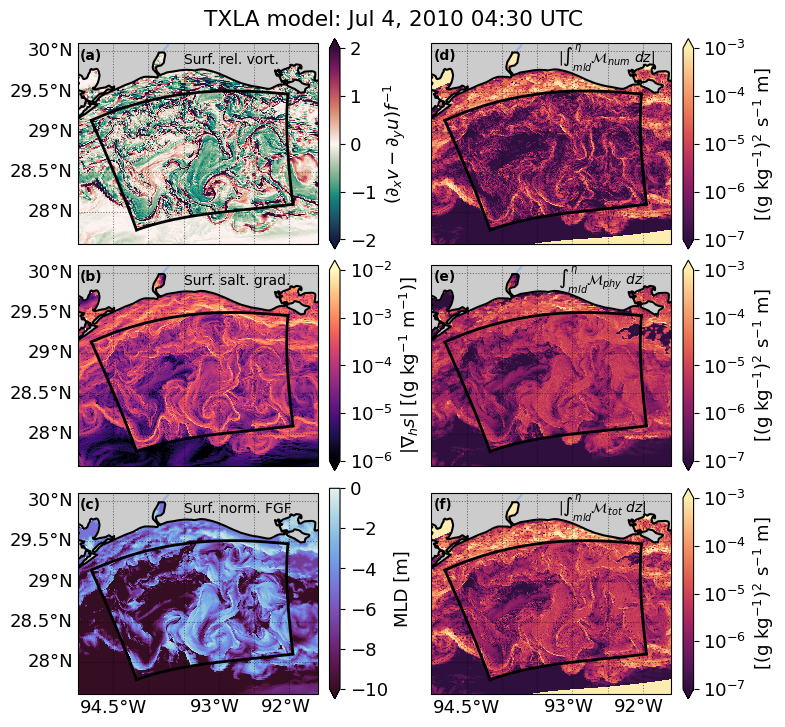

In [137]:
ncols = 2;nrows = 3
fig,ax = plt.subplots(nrows,ncols,figsize=(7.75,(12/5)*3), 
                      subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(dsp.lon_psi,
                              dsp.lat_psi,
                              rv_p, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())

mappable = ax[0,0].pcolormesh(dsc.lon_psi,
                              dsc.lat_psi,
                              rv_c, 
                              cmap = cmo.curl,
                              vmin = -2,
                              vmax = 2,
                              transform = ccrs.PlateCarree())


cb = fig.colorbar(mappable, ax = ax[0,0], orientation = 'vertical', 
                  extend = 'both', pad = 0.05)
cb.set_label(r'$(\partial_x v - \partial_y u)f^{-1}$')

mappable1 = ax[1,0].pcolormesh(dsp.lon_psi,
                            dsp.lat_psi,
                            np.log10(sgrad_p), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

mappable1 = ax[1,0].pcolormesh(dsc.lon_psi,
                            dsc.lat_psi,
                            np.log10(sgrad_c), 
                            cmap = plt.get_cmap('magma'),
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable1, ax = ax[1,0], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.05)
cb.set_label(r'$|\nabla_h s|$ [(g kg$^{-1}$ m$^{-1}$)]')

mappable2 = ax[2,0].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               -mldp_03_xroms_psi, 
                               cmap = cmo.dense_r,
                               vmin = -10,
                               vmax = 0,
                               transform = ccrs.PlateCarree())
mappable2 = ax[2,0].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                              -mldc_03_xroms_psi, 
                               cmap = cmo.dense_r,
                               vmin = -10,
                               vmax = 0,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable2, ax = ax[2,0], orientation = 'vertical', 
                  extend = 'min', pad = 0.05)
cb.set_label(r'MLD [m]')

mappable3 = ax[0,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mnum_p)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

mappable3 = ax[0,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mnum_c)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable3, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')


mappable4 = ax[1,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mphy_p)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

mappable4 = ax[1,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mphy_c)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable4, ax = ax[1,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

mappable5 = ax[2,1].pcolormesh(dsp.lon_psi,
                               dsp.lat_psi,
                               np.log10(np.abs(mtot_p)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

mappable5 = ax[2,1].pcolormesh(dsc.lon_psi,
                               dsc.lat_psi,
                               np.log10(np.abs(mtot_c)), 
                               cmap = cmo.matter_r,
                               vmin = -7,
                               vmax = -3,
                               transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.05, format=tick.FormatStrFormatter('$10^{%d}$'))
cb.set_label(r'[(g kg$^{-1}$)$^{2}$ s$^{-1}$ m]')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].add_feature(cartopy.feature.RIVERS, linewidth=1.5)
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect(lat_rad)
        ax[i,j].plot(dsc.lon_rho[0,:], 
                     dsc.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(dsc.lon_rho[:,0], 
                     dsc.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[:,-1], 
                     dsc.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(dsc.lon_rho[-1,:], 
                     dsc.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[i+1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[i+1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,0].annotate('Surf. rel. vort.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 10)
ax[1,0].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,0].annotate('Surf. salt. grad.', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 10)
ax[0,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[0,1].annotate(r'$\left|\int_{mld}^{\eta} \mathcal{M}_{num} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 10)
ax[1,1].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[1,1].annotate(r'$\int_{mld}^{\eta} \mathcal{M}_{phy} \, \, dz$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 10)
ax[2,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,0].annotate('Surf. norm. FGF', xy = (-93.5, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 10)
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10,  fontweight='bold')
ax[2,1].annotate(r'$\left|\int_{mld}^{\eta} \mathcal{M}_{tot} \, \, dz \right|$', xy = (-93.2, 29.85), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 10)

fig.suptitle("TXLA model: Jul 4, 2010 04:30 UTC")
fig.canvas.draw()
plt.savefig('txla_snap_int_mld.jpg', dpi = 800, bbox_inches='tight')